In [19]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import sin, asin, floor, sqrt, pi
import numpy as np
from scipy.linalg import sqrtm, fractional_matrix_power
from qiskit.circuit.library import RXGate
import matplotlib.pyplot as plt
from qiskit.quantum_info import Operator
from scipy.linalg import fractional_matrix_power


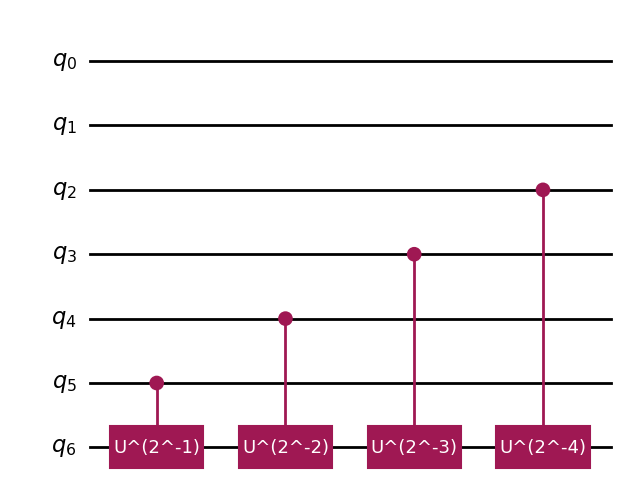

In [ ]:
def P(n: int, U) -> QuantumCircuit:
    qc = QuantumCircuit(n + 2, name="P")
    for k in reversed(range(2, n + 1)):
        U = sqrtm(U)
        cu_gate = UnitaryGate(U, label=f"U^(2^-{n - k + 1})").control(1)
        qc.append(cu_gate, [k, n + 1])

    return qc

U = np.array([
    [1, 0],
    [0, -1]
])

P(5, U).draw(output="mpl")

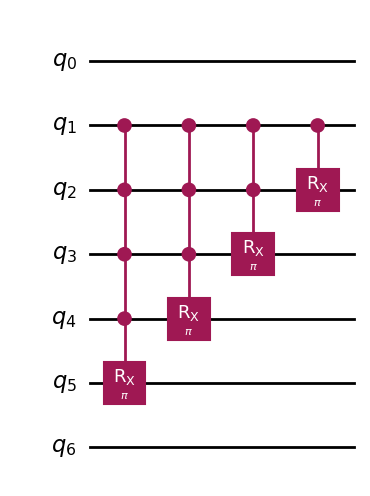

In [32]:
def Q(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n + 2, name="Q")
    for k in reversed(range(1, n)):
        qc.append(RXGate(pi).control(k), range(1, k + 2))
    
    return qc

Q(5).draw(output="mpl")

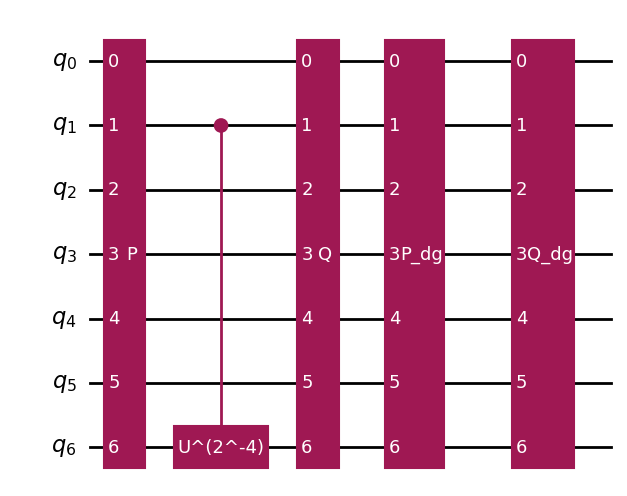

In [49]:
def multi_controlled_U(n: int, U) -> QuantumCircuit:
    qc = QuantumCircuit(n + 2)
    qc.append(P(n, U), range(n + 2))
    root_U = fractional_matrix_power(U, 2**(-n + 1))
    cu_gate = UnitaryGate(root_U, label=f"U^(2^-{n - 1})").control(1)
    qc.append(cu_gate, [1, n + 1])
    qc.append(Q(n), range(n + 2))
    qc.append(P(n, U).inverse(), range(n + 2))
    qc.append(Q(n).inverse(), range(n + 2))

    return qc

multi_controlled_U(5, U).draw(output="mpl")

In [69]:
def test_x(mcu: QuantumCircuit):
    n = mcu.num_qubits - 2
    qc = QuantumCircuit(n + 2)
    qc.x(range(1, n + 2))
    print(qc.draw(output="text"))
    qc.append(mcu, range(n + 2))
    qc.measure_all()

    backend = Aer.get_backend('aer_simulator')
    compiled = transpile(qc, backend)
    result = backend.run(compiled, shots=rounds).result()
    counts = result.get_counts(compiled)

    if counts.get("0" + "1" * n + "0") == rounds:
        print("Passed: applied all-1 test")
    else:
        print("Failed: did not apply all-1 test")

    qc = QuantumCircuit(n + 2)
    qc.x(range(2, n + 2))
    qc.append(mcu, range(n + 2))
    qc.measure_all()

    backend = Aer.get_backend('aer_simulator')
    compiled = transpile(qc, backend)
    result = backend.run(compiled, shots=rounds).result()
    counts = result.get_counts(compiled)

    if counts.get("0" + "1" * n + "0") != rounds:
        print("Passed: did not apply when first control is 0")
    else:
        print("Failed: still applied when first control is 0")


n = 5
rounds = 100

U = np.array([
    [0, 1],
    [1, 0]
])

mcu_gate = UnitaryGate(U).control(n)
qc = QuantumCircuit(n + 2)
qc.append(mcu_gate, range(1, n + 2))

print("Testing LLD multi-controlled-U:")
test_x(multi_controlled_U(5, U))
print("\nTesting Qiskit multi-controlled-U:")
test_x(qc)

Testing LLD multi-controlled-U:
          
q_0: ─────
     ┌───┐
q_1: ┤ X ├
     ├───┤
q_2: ┤ X ├
     ├───┤
q_3: ┤ X ├
     ├───┤
q_4: ┤ X ├
     ├───┤
q_5: ┤ X ├
     ├───┤
q_6: ┤ X ├
     └───┘
Passed: applied all-1 test
Passed: did not apply when first control is 0

Testing Qiskit multi-controlled-U:
          
q_0: ─────
     ┌───┐
q_1: ┤ X ├
     ├───┤
q_2: ┤ X ├
     ├───┤
q_3: ┤ X ├
     ├───┤
q_4: ┤ X ├
     ├───┤
q_5: ┤ X ├
     ├───┤
q_6: ┤ X ├
     └───┘
Passed: applied all-1 test
Passed: did not apply when first control is 0
